# Create a SBML Model With BioCRNpyler

In [1]:
from biocrnpyler import *

def pp(d, tabs = 0):
    txt = ""
    for v in d:
        if isinstance(d[v], dict):
            txt+="\n"+f"{'  '*tabs} {v} : {pp(d[v], tabs+1)}"
        else:
            txt+="\n"+f"{'  '*tabs} {v} : {d[v]}"
    return txt

In [2]:
H_in = Species("H", compartment = "internal")
H_out = Species("H", compartment = "external")
M = Species("M", compartment = "internal")

k = 1.0
K = 10
prop = ProportionalHillPositive(k = k, n = 1.0, d = M, s1 = H_in, K = K)
rxn = Reaction(inputs = [H_in], outputs = [H_out], propensity_type = prop)

CRN = ChemicalReactionNetwork(
    species = [H_in, H_out, M], 
    reactions = [rxn],
    initial_concentration_dict = {H_in:100, H_out:0, M:2})

print(CRN.pretty_print(show_compartment = True))

CRN.write_sbml_file("simple_transport.xml")

Species(N = 3) = {
H (@ 100),  M (@ 2),  H (@ 0),  
}

Reactions (1) = [
0. H --> H
 Kf = k M H^n / ( K^n + H^n )
  k=1.0
  K=10
  n=1.0

]


True

In [3]:
from vivarium.core.process import Process
import numpy as np

class Motion(Process):

    defaults = {"flux_velocity_ratio":0.001}

    def ports_schema(self):
        return {
            'location': {'_default':[0, 0], '_emit':True},
            'delta': { 'H': {}}
        }

    def next_update(self, timestep, states):
        
        x = states["location"][0]
        y = states["location"][1]
        deltaH = states["delta"]["H"]
        flux = deltaH/timestep
        
        vmag = flux*self.parameters["flux_velocity_ratio"]
        
        direction = np.random.normal(loc = 0, scale = 1, size = 2)
        direction = direction/np.sqrt(np.sum(direction**2))
        direction = direction*vmag
        
        return {
            'location':direction
        }

In [4]:
from vivarium.core import store
from vivarium_bioscrape.processes.bioscrape import Bioscrape

bs_parameters = {
    "sbml_file":"simple_transport.xml",
    "timestep": 1.0
}


#Create a Store
S = store.Store({})
S["crn"] = Bioscrape(bs_parameters)
S["motion"] = Motion({"time_step":1.0})
S["motion"].connect(("delta", "H"), S["crn", "delta_species", "H_internal"])
print(pp(S.get_value()))


 crn : (<vivarium_bioscrape.processes.bioscrape.Bioscrape object at 0x122a6cd30>, {'species': ('species',), 'delta_species': ('delta_species',), 'rates': ('rates',), 'globals': ('globals',)})
 species : 
   H_internal : 0.0
   H_external : 0.0
   M_internal : 0.0
 delta_species : 
   H_internal : 0.0
   H_external : 0.0
   M_internal : 0.0
 rates : 
   k : 1.0
   K : 10.0
   n : 1.0
 globals : 
   volume : 1.0
 motion : (<__main__.Motion object at 0x122a6cc10>, {'location': ('location',), 'delta': {'_path': ('delta',), 'H': ('..', 'delta_species', 'H_internal')}})
 location : [0, 0]
 delta : 
   H : None


In [5]:
%matplotlib inline
from vivarium.core.engine import Engine

sim = Engine(**{'store': S})

steps = 100
sim.update(steps)


print(pp(S.get_value()))


Simulation ID: 0aa332b8-9034-11ec-87b2-acde48001122
Created: 02/17/2022 at 12:56:13
Completed in 0.046783 seconds

 crn : (<vivarium_bioscrape.processes.bioscrape.Bioscrape object at 0x122a6cd30>, {'species': ('species',), 'delta_species': ('delta_species',), 'rates': ('rates',), 'globals': ('globals',)})
 species : 
   H_internal : 0.0
   H_external : 0.0
   M_internal : 0.0
 delta_species : 
   H_internal : 0.0
   H_external : 0.0
   M_internal : 0.0
 rates : 
   k : 1.0
   K : 10.0
   n : 1.0
 globals : 
   volume : 1.0
 motion : (<__main__.Motion object at 0x122a6cc10>, {'location': ('location',), 'delta': {'_path': ('delta',), 'H': ('..', 'delta_species', 'H_internal')}})
 location : [0. 0.]
 delta : 
   H : None


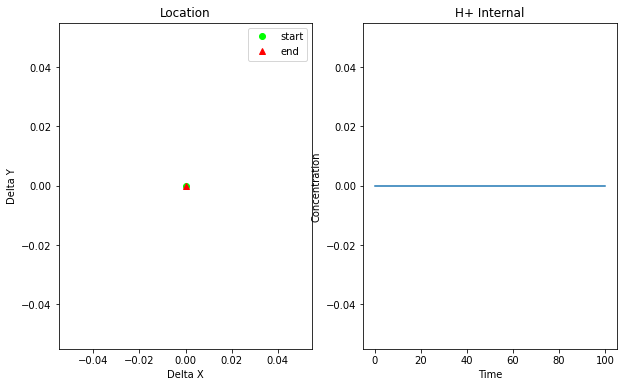

In [6]:
data = sim.emitter.get_timeseries()
time = data["time"]

plt.figure(figsize = (10, 6))
plt.subplot(121)
plt.title("Location")

plt.plot(data["location"][0][0], data["location"][1][0], 'o', label = "start", color = (0, 1, 0))
for i in range(len(time)-1):
    plt.plot([data["location"][i][0], data["location"][i+1][0]] , [data["location"][i][1], data["location"][i+1][1]], color = (i/steps, 1-i/steps, 0), alpha = .5)
plt.plot(data["location"][-1][0], data["location"][-1][1], '^', label = "end", color = (1, 0, 0))
plt.legend()
plt.xlabel("Delta X")
plt.ylabel("Delta Y")

plt.subplot(122)
plt.title("H+ Internal")
plt.plot(time, data["species"]["H_internal"])
plt.xlabel("Time")
plt.ylabel("Concentration")
plt.show()